# This is a dataset from Kaggle, looking at a bit under 1.6 million beer reviews from BeerAdvocate from about 1996 to 2012.

The main goal of this dataset is to build a recommendation system from user reviews. 

In this dataset I go over a few things:

1. Understanding the dataset quality.

2. Data cleaning (e.g. time conversion, approximating missing values, etc.).

3. Answering questions I came up with by exploring the data.

4. Visualizing questions I came up with.

5. Building a recommender system based on correlation of user reviews, based on user input.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('ticks')
%matplotlib inline
from datetime import datetime

import panel as pn
pn.extension()

In [2]:
df = pd.read_csv('beer_reviews.csv')

In [3]:
df.head()

,brewery_id,brewery_name,review_time,review_overall,review_aroma,review_appearance,review_profilename,beer_style,review_palate,review_taste,beer_name,beer_abv,beer_beerid
0,10325,Vecchio Birraio,1234817823,1.5,2.0,2.5,stcules,Hefeweizen,1.5,1.5,Sausa Weizen,5.0,47986
1,10325,Vecchio Birraio,1235915097,3.0,2.5,3.0,stcules,English Strong Ale,3.0,3.0,Red Moon,6.2,48213
2,10325,Vecchio Birraio,1235916604,3.0,2.5,3.0,stcules,Foreign / Export Stout,3.0,3.0,Black Horse Black Beer,6.5,48215
3,10325,Vecchio Birraio,1234725145,3.0,3.0,3.5,stcules,German Pilsener,2.5,3.0,Sausa Pils,5.0,47969
4,1075,Caldera Brewing Company,1293735206,4.0,4.5,4.0,johnmichaelsen,American Double / Imperial IPA,4.0,4.5,Cauldron DIPA,7.7,64883


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1586614 entries, 0 to 1586613
Data columns (total 13 columns):
 #   Column              Non-Null Count    Dtype  
---  ------              --------------    -----  
 0   brewery_id          1586614 non-null  int64  
 1   brewery_name        1586599 non-null  object 
 2   review_time         1586614 non-null  int64  
 3   review_overall      1586614 non-null  float64
 4   review_aroma        1586614 non-null  float64
 5   review_appearance   1586614 non-null  float64
 6   review_profilename  1586266 non-null  object 
 7   beer_style          1586614 non-null  object 
 8   review_palate       1586614 non-null  float64
 9   review_taste        1586614 non-null  float64
 10  beer_name           1586614 non-null  object 
 11  beer_abv            1518829 non-null  float64
 12  beer_beerid         1586614 non-null  int64  
dtypes: float64(6), int64(3), object(4)
memory usage: 157.4+ MB


In [5]:
df.isnull().sum()

brewery_id                0
brewery_name             15
review_time               0
review_overall            0
review_aroma              0
review_appearance         0
review_profilename      348
beer_style                0
review_palate             0
review_taste              0
beer_name                 0
beer_abv              67785
beer_beerid               0
dtype: int64

A few notes, so far:

1. Timestamp can be converted from epoch time.
2. Beer ABV can be approximated by the average of the style. While I could drop ~5% of NaN data, I would prefer not to.
3. Brewery name and review profile name can be dropped, losing about 363 reviews out of ~1.6 million

In [6]:
abv_means = df['beer_abv'].groupby(df['beer_style']).transform('mean')
#Measures the mean of the different beer styles for all reviews, and lists them as such
#Using .agg('mean') would have grouped the unique styles rather than applying the mean to all reviews, per style


In [7]:
df['beer_abv'] = df['beer_abv'].fillna(abv_means)

Converting the epoch time to datetime

In [8]:
df['review_time'] = df['review_time'].apply(lambda x: datetime.fromtimestamp(x))
df['review_time'].head()

0   2009-02-16 15:57:03
1   2009-03-01 08:44:57
2   2009-03-01 09:10:04
3   2009-02-15 14:12:25
4   2010-12-30 13:53:26
Name: review_time, dtype: datetime64[ns]

In [9]:
df.isnull().sum()

brewery_id              0
brewery_name           15
review_time             0
review_overall          0
review_aroma            0
review_appearance       0
review_profilename    348
beer_style              0
review_palate           0
review_taste            0
beer_name               0
beer_abv                0
beer_beerid             0
dtype: int64

In [10]:
df = df.dropna()

# Data Questions

### Is there a brewery that consistently puts out well-reviewed beer?

Look for a brewery that puts out more than 5 beers at 4.5 stars, that has at least 10 votes

In [11]:
df_brewery = df['review_overall'].groupby([df['brewery_name'],df['beer_name']]).agg(['mean','count'])
df_brewery

mean  count
brewery_name         beer_name                             
't Hofbrouwerijke    Blondelle              4.000000      1
                     Bosprotter             3.722222      9
                     Hof Korvatunturi       3.750000      2
                     Hofblues               3.812500     16
                     Hofdraak               3.357143      7
...                                              ...    ...
Ørbæk Bryggeri       Nutty Nut Brown Ale    3.500000      2
                     Old Danish Braggot     3.666667      3
                     Pale Ale               4.250000      2
                     WeissBier Hyldeblomst  3.500000      1
Łódzkie Browary S.A. Porter &#321;ódzki     3.500000      1

[65675 rows x 2 columns]

In [12]:
df_brewery[(df_brewery['mean']>= 4.5) & (df_brewery['count']>=10)].groupby(level = 'brewery_name').size().nlargest(5)

brewery_name
Brouwerij Drie Fonteinen             8
Russian River Brewing Company        6
The Lost Abbey                       5
Port Brewing Company / Pizza Port    4
COAST Brewing Company                3
dtype: int64

### Is there a brewery that puts out consistently poorly reviewed beer?

In [13]:
df_brewery[(df_brewery['mean']<=2) & (df_brewery['count']>=10)].groupby(level = 'brewery_name').size().nlargest(5)

brewery_name
Anheuser-Busch                     6
Camo Brewing Company               4
City Brewing Company, LLC          4
Cold Spring Brewing Co.            4
Cervecera Mexicana S.A. De C.V.    2
dtype: int64

### What are the most popular, best reviewed beers? E.g. beers that have more than 1000 ratings 

In [14]:
df_popular_beer = df['review_overall'].groupby(df['beer_name']).agg(['count','mean'])
df_popular_beer.head()

,count,mean
beer_name,,
! (Old Ale),1,4.0
"""100""",5,4.0
"""100"" Pale Ale",1,4.0
"""12"" Belgian Golden Strong Ale",2,4.0
"""33"" Export",3,3.0


In [15]:
df_popular_beer[df_popular_beer['count'] >= 1000].sort_values(['mean','count'], ascending=False).head(5)

,count,mean
beer_name,,
Trappist Westvleteren 12,1272,4.617925
Pliny The Elder,2527,4.590028
Weihenstephaner Hefeweissbier,1980,4.516414
The Abyss,1412,4.450779
Sculpin India Pale Ale,1352,4.437870


### Who has reviewed the most beers?

In [16]:
df['review_profilename'].value_counts().nlargest(5)

northyorksammy    5817
BuckeyeNation     4661
mikesgroove       4617
Thorpe429         3518
womencantsail     3497
Name: review_profilename, dtype: int64

### How many users have only left 1 review?

In [17]:
df_reviewers = df.groupby(df['review_profilename']).agg('count')['brewery_id'].rename('review_count')
df_reviewers.count()

33387

In [18]:
len(df_reviewers[df_reviewers == 1])

10443

### What beers have a large gap between palate and taste? 

As taste is a part of palate, it'd be interesting to note that.

In [19]:
df_gap = pd.DataFrame(data = {})
df_gap['beer_name'] = df['beer_name']
df_gap['beer_style'] = df['beer_style']
df_gap['palate-taste-gap'] = df['review_palate']-df['review_taste']
df_gap['appearance-taste-gap'] = df['review_appearance']-df['review_taste']
df_gap.head()

,beer_name,beer_style,palate-taste-gap,appearance-taste-gap
0,Sausa Weizen,Hefeweizen,0.0,1.0
1,Red Moon,English Strong Ale,0.0,0.0
2,Black Horse Black Beer,Foreign / Export Stout,0.0,0.0
3,Sausa Pils,German Pilsener,-0.5,0.5
4,Cauldron DIPA,American Double / Imperial IPA,-0.5,-0.5


In [20]:
df_pt_gap = df_gap['palate-taste-gap'].groupby(df['beer_name']).agg(['count','mean'])
df_pt_gap.head()

,count,mean
beer_name,,
! (Old Ale),1,-0.500000
"""100""",5,-0.400000
"""100"" Pale Ale",1,0.000000
"""12"" Belgian Golden Strong Ale",2,0.250000
"""33"" Export",3,0.166667


In [21]:
df_pt_gap[(df_pt_gap['count'] >= 3) & ((df_pt_gap['mean']>=1.5) | (df_pt_gap['mean'] <= -1.5))]

,count,mean
beer_name,,
Alesmith Speedway Stout - Dry Hopped W/ Slovenian Hops,4,1.75
Crazy Snake,3,1.50
Hop Secret,3,1.50


### What beers have a large gap between taste and appearance rating?

In [22]:
df_at_gap = df_gap['appearance-taste-gap'].groupby(df['beer_name']).agg(['count','mean'])
df_at_gap.head()

,count,mean
beer_name,,
! (Old Ale),1,-0.50
"""100""",5,-0.40
"""100"" Pale Ale",1,-0.50
"""12"" Belgian Golden Strong Ale",2,-0.25
"""33"" Export",3,0.00


In [23]:
df_at_gap[(df_at_gap['count'] >=3)& ((df_at_gap['mean']>=2) | (df_at_gap['mean'] <= -2))]

,count,mean
beer_name,,
Alesmith Speedway Stout - Dry Hopped W/ Slovenian Hops,4,2.500000
Bear Mountain Ale,4,2.125000
Catch Lager,3,2.000000
Hop Secret,3,2.333333
Kriek Extra,4,2.500000
Marisa,4,2.125000
Oink Oink Ale,3,2.166667
Oktober Chest,3,2.000000


Interestingly, Alesmith Speedway Stout topped both the palate and appearance charts.

In other words, the 4 people who reviewed it thought the beer looked good and had a good "feel", but it tasted poorly 

In [24]:
df[df['beer_name'] == 'Alesmith Speedway Stout - Dry Hopped W/ Slovenian Hops']

,brewery_id,brewery_name,review_time,review_overall,review_aroma,review_appearance,review_profilename,beer_style,review_palate,review_taste,beer_name,beer_abv,beer_beerid
184656,396,AleSmith Brewing Company,2011-11-30 23:53:21,3.0,3.0,4.5,DarthKostrizer,American Double / Imperial Stout,3.5,2.0,Alesmith Speedway Stout - Dry Hopped W/ Sloven...,12.0,75220
184657,396,AleSmith Brewing Company,2011-11-20 14:10:15,2.5,3.0,4.5,notchucknorris,American Double / Imperial Stout,4.5,2.5,Alesmith Speedway Stout - Dry Hopped W/ Sloven...,12.0,75220
184658,396,AleSmith Brewing Company,2011-11-13 20:50:04,2.0,2.0,5.0,ehammond1,American Double / Imperial Stout,4.0,2.0,Alesmith Speedway Stout - Dry Hopped W/ Sloven...,12.0,75220
184659,396,AleSmith Brewing Company,2011-11-13 14:14:40,2.0,2.5,4.0,brew3crew,American Double / Imperial Stout,3.0,1.5,Alesmith Speedway Stout - Dry Hopped W/ Sloven...,12.0,75220


### How well does one of my favorite local breweries do, Taxman? 

In [25]:
df[df['brewery_name'].fillna('').str.contains('Taxman', case = False)]

,brewery_id,brewery_name,review_time,review_overall,review_aroma,review_appearance,review_profilename,beer_style,review_palate,review_taste,beer_name,beer_abv,beer_beerid


### No entries yet! They were founded in 2014...When were the reviews captured?

In [26]:
print(df['review_time'].min())
print(df['review_time'].max())

1996-08-21 20:00:01
2012-01-11 07:35:48


### What about another local brewery, Sun King?

In [27]:
sk_beers = df.groupby(['brewery_name','beer_name']).count().loc['Sun King Brewing Company']
sk_beers['review_count'] = sk_beers['brewery_id'].rename('review_count')
sk_beer_num = len(sk_beers.index)
sk_beer_num

64

In [28]:
sk_rating = df[df['brewery_name'] == 'Sun King Brewing Company']['review_overall'].mean()
sk_rating = str(round(sk_rating,2))
float(sk_rating)

3.98

In [29]:
sk_reviewers = df[df['brewery_name'] == 'Sun King Brewing Company']['review_profilename'].nunique()
sk_reviewers

220

Sun King Brewery has 64 beers reviewed, all rated at an average of 3.98 out of 5 stars by a total of 220 unique reviewers.

#### What beer styles get the best ratings? Worst ratings?

In [30]:
df.groupby('beer_style').mean()['review_overall'].sort_values(ascending=False)[0:5]

beer_style
American Wild Ale                   4.093262
Gueuze                              4.086399
Quadrupel (Quad)                    4.071666
Lambic - Unblended                  4.048923
American Double / Imperial Stout    4.029746
Name: review_overall, dtype: float64

In [31]:
df.groupby('beer_style').mean()['review_overall'].sort_values(ascending=True)[0:5]

beer_style
Low Alcohol Beer        2.578268
American Malt Liquor    2.679200
Light Lager             2.698700
Euro Strong Lager       2.862518
Happoshu                2.914938
Name: review_overall, dtype: float64

### What beer style has the largest alcohol % in it, on average?

In [32]:
df.groupby('beer_style').mean()['beer_abv'].sort_values(ascending=False)[0:5]

beer_style
Eisbock                            11.392852
English Barleywine                 10.918061
American Barleywine                10.703679
Wheatwine                          10.662535
Bière de Champagne / Bière Brut    10.622863
Name: beer_abv, dtype: float64

# Data Visualization


### Total number of ratings over time, with hue of 5 most popular beer styles 

In [33]:
df.head(0)

,brewery_id,brewery_name,review_time,review_overall,review_aroma,review_appearance,review_profilename,beer_style,review_palate,review_taste,beer_name,beer_abv,beer_beerid


In [34]:
top5 = df['beer_style'].value_counts()[0:5].index.to_list()
top5

['American IPA',
 'American Double / Imperial IPA',
 'American Pale Ale (APA)',
 'Russian Imperial Stout',
 'American Double / Imperial Stout']

In [35]:
df_time = df[df['beer_style'].isin(top5)].sort_values('review_time')
df_time.head()

,brewery_id,brewery_name,review_time,review_overall,review_aroma,review_appearance,review_profilename,beer_style,review_palate,review_taste,beer_name,beer_abv,beer_beerid
564601,33,Berkshire Brewing Company Inc.,1996-08-21 20:00:01,4.0,3.5,3.5,Todd,American Pale Ale (APA),4.0,4.0,Steel Rail Extra Pale Ale,5.300000,93
1037602,100,McNeill's Brewery,1998-02-16 19:00:01,4.0,3.5,4.0,Todd,American Pale Ale (APA),3.0,3.5,McNeill's Champ Ale,5.500000,324
921918,155,Upper Canada Brewing Company,1998-02-18 19:00:01,2.5,3.0,4.0,BeerAdvocate,American Pale Ale (APA),2.0,2.0,Rebellion Ale,5.469752,46
921891,155,Upper Canada Brewing Company,1998-02-18 19:00:01,3.0,4.0,4.0,BeerAdvocate,American Pale Ale (APA),2.5,3.0,Woody's Wild Ale,5.469752,45
358300,115,"Old Nutfield Brewing Company, Ltd.",1998-02-18 19:00:01,4.0,3.0,3.0,BeerAdvocate,American Pale Ale (APA),3.5,4.0,Nutfield Nor'Easter,5.469752,2387


In [36]:
df_time_count = df_time['review_overall'].groupby([df_time['beer_style'], df_time['review_time'].dt.year.rename('year')],sort=False).agg('count').reset_index()
df_time_count.head()

,beer_style,year,review_overall
0,American Pale Ale (APA),1996,1
1,American Pale Ale (APA),1998,14
2,American IPA,1998,5
3,Russian Imperial Stout,1998,2
4,American Double / Imperial Stout,1998,1


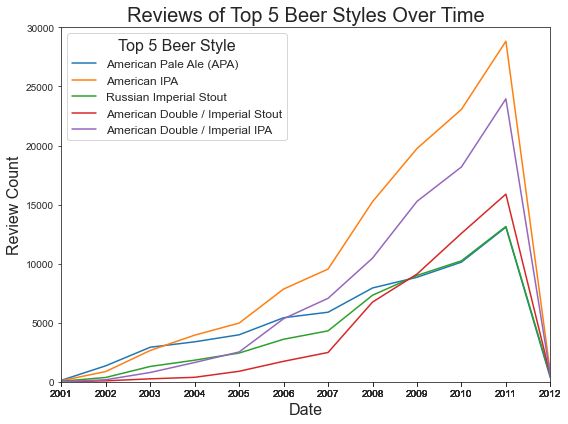

In [37]:
plt.figure(figsize=(8,6))
review_over_time = sns.lineplot(data = df_time_count, y = 'review_overall', x = 'year', hue = 'beer_style', ci = None)
review_over_time.set_xticks(df_time_count['year'])
review_over_time.set_xlabel('Date', fontsize = 16)
review_over_time.set_ylabel('Review Count', fontsize = 16)
review_over_time.legend(title = 'Top 5 Beer Style', fontsize = 12, title_fontsize=16)
review_over_time.set_title('Reviews of Top 5 Beer Styles Over Time', fontsize = 20)
review_over_time.set_ylim(0,30000)
review_over_time.set_xlim(2001,2012)
plt.tight_layout()


### Plot abv vs overall review 

In [38]:
df_review_abv = df['review_overall'].groupby([df['beer_name'],df['beer_abv']]).agg('mean').reset_index()
df_review_abv

,beer_name,beer_abv,review_overall
0,! (Old Ale),8.2,4.000000
1,"""100""",10.0,4.000000
2,"""100"" Pale Ale",6.6,4.000000
3,"""12"" Belgian Golden Strong Ale",9.0,4.000000
4,"""33"" Export",4.8,3.000000
...,...,...,...
61902,Žamberecký Kanec Imperial Stout,5.5,3.750000
61903,Ω-naught (Omeganaught),5.0,4.166667
61904,“Chewy” Double IPA,6.9,2.500000
61905,横須賀ビアサケ (Yokosuka Biasake),5.5,4.000000


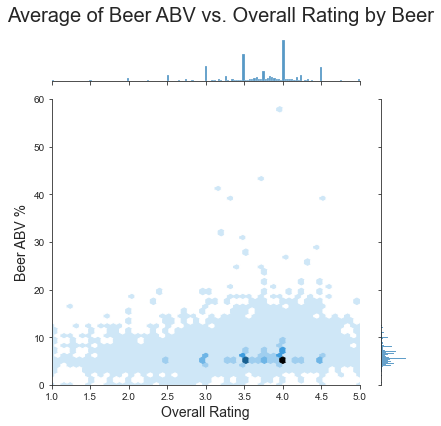

In [39]:
review_abv_fig = sns.jointplot(data = df_review_abv, x = 'review_overall', y= 'beer_abv', kind='hex', bins = 10, xlim = (1,5), ylim = (0,60))
review_abv_fig.set_axis_labels('Overall Rating', 'Beer ABV %', fontsize = 14)
review_abv_fig.fig.suptitle('Average of Beer ABV vs. Overall Rating by Beer', fontsize = 20)
plt.tight_layout()

### Is palette review corelated with taste review?

In [40]:
taste_palate = df[['review_taste','review_palate']].groupby(df['beer_name']).agg('mean')
taste_palate.head()

,review_taste,review_palate
beer_name,,
! (Old Ale),4.5,4.000000
"""100""",4.4,4.000000
"""100"" Pale Ale",4.0,4.000000
"""12"" Belgian Golden Strong Ale",4.5,4.750000
"""33"" Export",3.0,3.166667


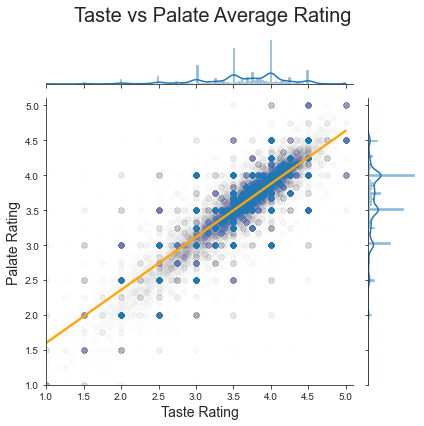

In [41]:
palate_taste = sns.jointplot(data = taste_palate, x = 'review_taste', y= 'review_palate', kind='reg',
                             joint_kws = {'scatter_kws':dict(alpha=0.005), 'line_kws':{'color':'orange'}}, xlim = (1,5.1), ylim = (1,5.1))
                             
palate_taste.set_axis_labels('Taste Rating','Palate Rating', fontsize = 14)
palate_taste.fig.suptitle('Taste vs Palate Average Rating', fontsize = 20)
plt.tight_layout()

### Is there anything left in terms of correlation that I am missing?

Text(0.5, 1.0, 'Correlation of Numerical Features')

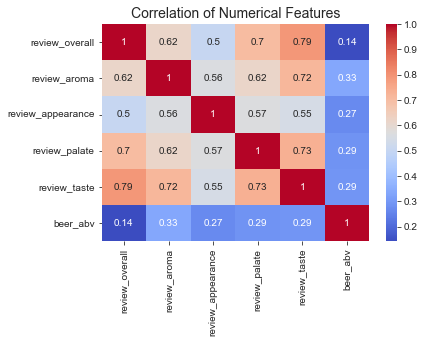

In [42]:
corr = sns.heatmap(df.drop(['brewery_id','beer_beerid'],axis=1).corr(), cmap = 'coolwarm', annot=True)
corr.set_title('Correlation of Numerical Features',fontsize = 14)

### Plot beer abv vs style for the highest abv 

In [43]:
top5abv = df.groupby('beer_style').mean()['beer_abv'].sort_values(ascending=False)[0:5].to_frame().reset_index()
top5abv

,beer_style,beer_abv
0,Eisbock,11.392852
1,English Barleywine,10.918061
2,American Barleywine,10.703679
3,Wheatwine,10.662535
4,Bière de Champagne / Bière Brut,10.622863


In [44]:
bottom5abv = df.groupby('beer_style').mean()['beer_abv'].sort_values(ascending=True)[0:5].to_frame().reset_index()
bottom5abv

,beer_style,beer_abv
0,Low Alcohol Beer,0.566706
1,Kvass,2.006987
2,Light Lager,4.031086
3,English Dark Mild Ale,4.064295
4,Berliner Weissbier,4.222682


In [45]:
top_bottom_abv = pd.concat([top5abv,bottom5abv],axis=0).sort_values(by='beer_abv')
top_bottom_abv[3:7]

,beer_style,beer_abv
3,English Dark Mild Ale,4.064295
4,Berliner Weissbier,4.222682
4,Bière de Champagne / Bière Brut,10.622863
3,Wheatwine,10.662535


In [46]:
top_bottom_abv.index

Int64Index([0, 1, 2, 3, 4, 4, 3, 2, 1, 0], dtype='int64')

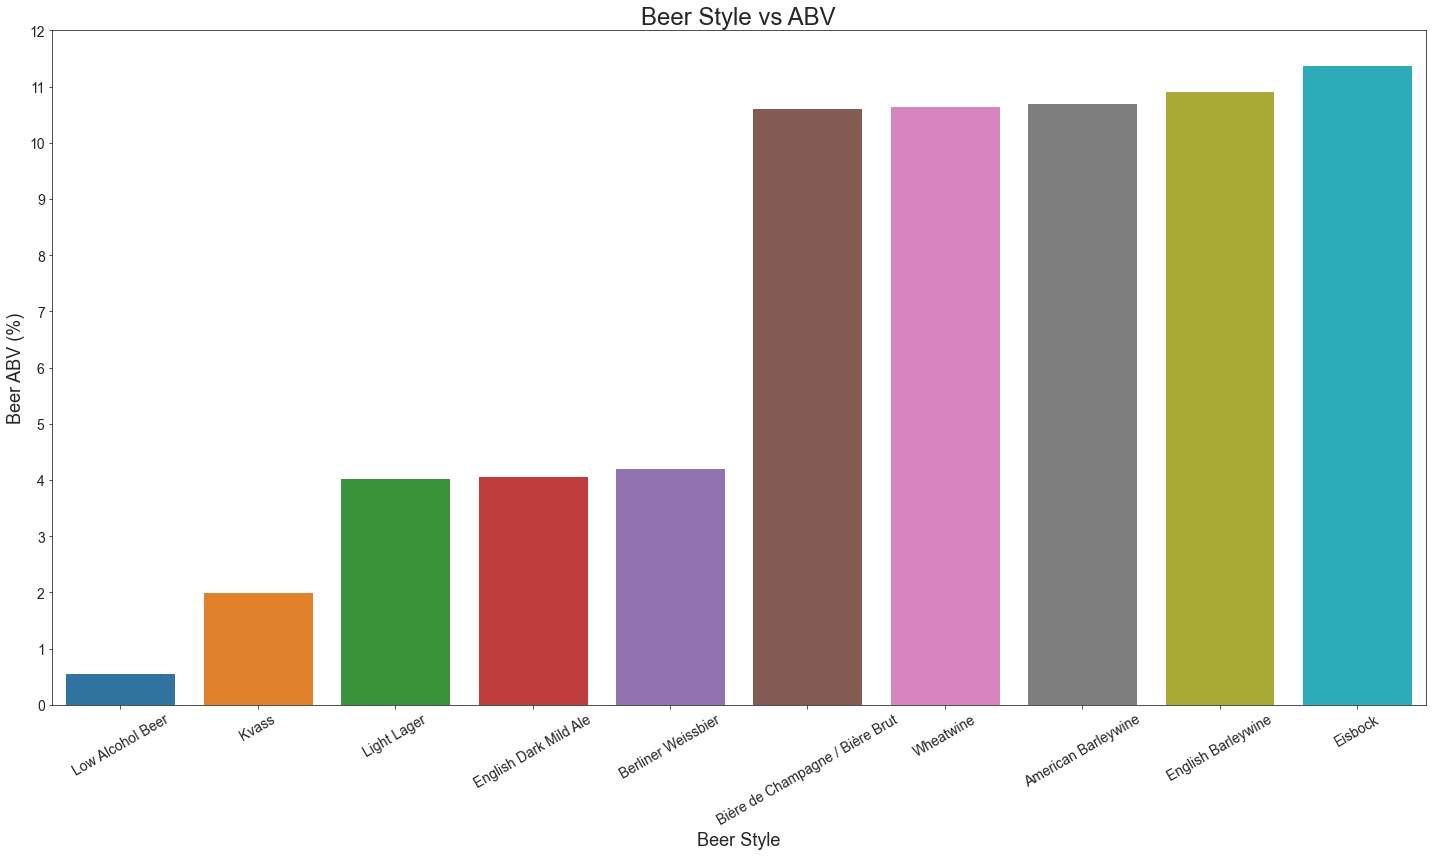

In [47]:
plt.figure(figsize=(20,12))
abv_style = sns.barplot(data = top_bottom_abv, x = 'beer_style', y = 'beer_abv')
abv_style.set_xlabel('Beer Style', fontsize = 18)
abv_style.set_xticks([i for i in range(10)])
abv_style.set_xticklabels(abv_style.get_xticklabels(),rotation = 30,fontsize = 14)

abv_style.set_ylabel('Beer ABV (%)', fontsize = 18)
abv_style.set_yticks([i for i in range(13)])
abv_style.set_yticklabels([i for i in abv_style.get_yticks()], fontsize = 14)
abv_style.set_title('Beer Style vs ABV', fontsize = 24)


plt.tight_layout()

### When do people want to review? e.g. days vs months, hour vs days in week

In [48]:
data_timestamp = pd.DataFrame(data={})
data_timestamp['year']=df['review_time'].dt.year
data_timestamp['month']=df['review_time'].dt.month
data_timestamp['dayofweek']=df['review_time'].dt.day_of_week
data_timestamp['hour']=df['review_time'].dt.hour

dow = {0:'Mon',1:'Tue',2:'Wed',3:'Thu',4:'Fri',5:'Sat',6:'Sun'} 
month = {1:'Jan',2:'Feb',3:'Mar',4:'Apr',5:'May',6:'Jun',7:'Jul',8:'Aug',9:'Sep',10:'Oct',11:'Nov',12:'Dec'}

data_timestamp['dayofweek'] = data_timestamp['dayofweek'].map(lambda key: dow[key])
data_timestamp['month'] = data_timestamp['month'].map(lambda key: month[key])
#All I am doing in the above is breaking down review dates into the hours, day of week, month, and year they were reviewed.

In [49]:
data_timestamp.head()

,year,month,dayofweek,hour
0,2009,Feb,Mon,15
1,2009,Mar,Sun,8
2,2009,Mar,Sun,9
3,2009,Feb,Sun,14
4,2010,Dec,Thu,13


In [50]:
dow_hour = data_timestamp[['dayofweek','hour']]
dow_hour = dow_hour.assign(review_overall = df['review_overall'])
dow_hour.head()

,dayofweek,hour,review_overall
0,Mon,15,1.5
1,Sun,8,3.0
2,Sun,9,3.0
3,Sun,14,3.0
4,Thu,13,4.0


In [51]:
dow_hour_corr = dow_hour.groupby(['hour','dayofweek'],sort=True).count()['review_overall'].unstack()
dow_hour_corr = dow_hour_corr[['Mon','Tue','Wed','Thu','Fri','Sat','Sun']]
dow_hour_corr.head()

dayofweek,Mon,Tue,Wed,Thu,Fri,Sat,Sun
hour,,,,,,,
0,11349,12520,12645,12549,12356,13044,12972
1,7489,8039,8122,7963,8002,8913,9343
2,5079,5175,5054,4978,5269,5795,6057
3,3256,3415,3349,3253,3328,3762,3730
4,2367,2248,2211,2239,2141,2400,2574


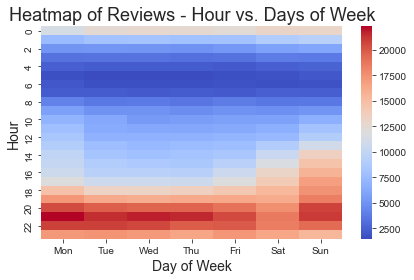

In [52]:
dow_hour_heatmap = sns.heatmap(dow_hour_corr,cmap='coolwarm')
dow_hour_heatmap.set_xlabel('Day of Week', fontsize = 14)
dow_hour_heatmap.set_ylabel('Hour', fontsize = 14)
dow_hour_heatmap.set_title('Heatmap of Reviews - Hour vs. Days of Week', fontsize = 18)
plt.tight_layout()

In [53]:
dow_month = data_timestamp[['dayofweek','month']]
dow_month = dow_month.assign(review_overall=df['review_overall'])
dow_month.head()

,dayofweek,month,review_overall
0,Mon,Feb,1.5
1,Sun,Mar,3.0
2,Sun,Mar,3.0
3,Sun,Feb,3.0
4,Thu,Dec,4.0


In [54]:
dow_month_corr = dow_month.groupby(['dayofweek','month']).count()['review_overall'].unstack()
dow_month_corr = dow_month_corr[['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec']]
dow_month_corr = dow_month_corr.loc[['Mon','Tue','Wed','Thu','Fri','Sat','Sun']]
dow_month_corr

month,Jan,Feb,Mar,Apr,May,Jun,Jul,Aug,Sep,Oct,Nov,Dec
dayofweek,,,,,,,,,,,,
Mon,20821,17605,19501,16569,19748,17759,18357,20655,18989,20213,20772,21518
Tue,18661,16011,18411,16297,17613,17584,17770,19375,18105,18336,19931,20402
Wed,17884,15922,18169,16805,16471,17261,17208,19112,17888,18045,19548,21563
Thu,18168,15933,17873,16856,16759,16546,17816,17714,18399,18751,17988,21474
Fri,19413,17555,16940,17841,17669,16412,18523,17713,18176,19175,18504,21785
Sat,22064,18366,18730,18089,18198,16285,18244,18971,17939,19453,20489,21478
Sun,25065,20612,21017,19027,21088,18374,20478,22738,19809,21876,23910,23089


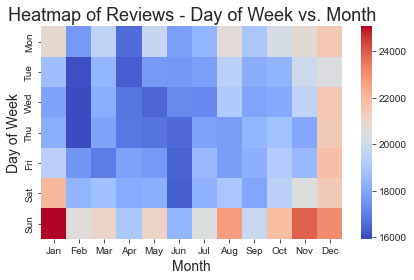

In [55]:
dow_year_heatmap = sns.heatmap(dow_month_corr,cmap='coolwarm')
dow_year_heatmap.set_xlabel('Month', fontsize = 14)
dow_year_heatmap.set_ylabel('Day of Week', fontsize = 14)
dow_year_heatmap.set_title('Heatmap of Reviews - Day of Week vs. Month', fontsize = 18)
plt.tight_layout()

# Insights from Predictions

### Similar beer style recommendations based off 30+ reviews per beer

In [56]:
df_beer = df[df['beer_name'].map(df['beer_name'].value_counts() > 30)]
mat = df_beer.pivot_table(index = 'review_profilename', columns = 'beer_name', values ='review_overall')

In [57]:
autocomplete = pn.widgets.AutocompleteInput(
   name='Beer Selection', options=[item for item in df['review_overall'].groupby(df['beer_name']).count().index.tolist()],
   placeholder='Type a beer that you\'re familiar with to receive similar suggestions')
pn.Row(autocomplete, height=100)

Row(height=100)
    [0] AutocompleteInput(name='Beer Selection', options=['! (Old Ale)', ...], placeholder="Type a beer t...)

In [63]:
beer_choice = autocomplete.value
beer = mat[beer_choice]

similar_beer = mat.corrwith(beer).dropna().to_frame()
similar_beer.columns = ['Correlation with '+ beer_choice]
df_choice = similar_beer.sort_values(by = 'Correlation with ' + beer_choice, ascending=False)[1:6]
print('\n')

df_choice

,Correlation with La Fin Du Monde
beer_name,
St. Austell Tribute Premium Cornish Ale,0.771671
Black Flag Imperial Stout (Hop Harvest Edition),0.753119
Tui East India Pale Ale,0.693137
Quincedence,0.679100
George,0.673476


# Insights from Exploratory Data Analysis

1.58 million reviews analyzed between 8/21/1996 and 1/11/2012

104 unique beer styles reviewed

57k beers were reviewed

44k beers of the 57k have 10 reviews or less

Of the 33k reviewers, about 10k have left only 1 review

User northyorksammy has left 5.8k reviews, the \#1 reviewer

Trappist Westvletern, Pliny the Elder, Weihenstephaner Hefeweissbier, The Abyss, and Sculpin India Pale Ale are the highest rated, most popular beers with more than 1000 reviews.

On average, the highest rated style of beer is the American Wild Ale, Gueze, Quadrupel, Lambic unblended, and American Double Imperial Stout.

The rating of taste and overall rating of the beer has the strongest correlation. 

Eisbocks have the highest ABV for beer style, and Low-Alcohol beer has well...the lowest Alcohol % of all beers

Sunday through Thursday around 21:00 UTC (~5PM EST) is the most common time to leave reviews.

Winter months on Sunday is the most common time to leave a review